### Weight derivation Sherpa vs. Madgraph
The idea behind this notebook is to compare two samples, more precisely the V+jets process generated using Sherpa and MadGraph5, and derive a weight to reweight Sherpa to look like MadGraph5. 

The reweighting technique (that learns "CARL weights") is based on Approximating Likelihood Ratios with Calibrated Discriminative Classifiers.

The performance of the weights, i.e. how well the reweighted original distribution matches the target distribution, is assessed by training a discriminator to differentiate the original distribution with weights applied from a target distribution.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import logging
import numpy as np
import root_numpy
from matplotlib import pyplot as plt
import torch
import sklearn
%matplotlib inline

Welcome to JupyROOT 6.20/02


In [2]:
from ml import RatioEstimator
from ml import Loader

### Load the data


In [3]:
storage = 'https://mvesterb.web.cern.ch/mvesterb/atlas/PMG/data_to_download/'
!wget -O data/sherpa.root -nc $storage/sherpa.root?raw=true
!wget -O data/madgraph.root -nc $storage/madgraph.root?raw=true

File `data/sherpa.root' already there; not retrieving.
File `data/madgraph.root' already there; not retrieving.


In [4]:
from ml.utils.tools import load
variables = ['VpT','Njets','j1pT', 'j2pT', 'HT','ptmiss', 'l1pT','Veta','j1eta','j2eta']

original = load('data/sherpa.root',   variables=variables)
target   = load('data/madgraph.root', variables=variables)

Load the dataframes and plot some distributions to be used for the training

In [5]:
loading = Loader()
do = "sherpaVsMG5"

x, y = loading.loading(
folder='./data/',
plot=False,
do = do,
x0 = original,
x1 = target
)

Define the PyTorch model and train it

In [6]:
estimator = RatioEstimator(
    n_hidden=(10,10),
    activation="sigmoid"
)

In [7]:
estimator.train(
    method='carl',
    batch_size = 128,
    n_epochs = 40,
    x='data/'+do+'/x_train.npy',
    y='data/'+do+'/y_train.npy',
    scale_inputs = True,
);

INFO:ml.ratio:Starting training
INFO:ml.ratio:  Method:                 carl
INFO:ml.ratio:  Batch size:             128
INFO:ml.ratio:  Optimizer:              amsgrad
INFO:ml.ratio:  Epochs:                 40
INFO:ml.ratio:  Learning rate:          0.001 initially, decaying to 0.0001
INFO:ml.ratio:  Validation split:       0.25
INFO:ml.ratio:  Early stopping:         True
INFO:ml.ratio:  Scale inputs:           True
INFO:ml.ratio:  Samples:                all
INFO:ml.ratio:Loading training data
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x_train.npy into RAM
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/y_train.npy into RAM
INFO:ml.ratio:Found 41962 samples with 10 observables
INFO:ml.base:Setting up input rescaling
INFO:ml.ratio:Creating model
INFO:ml.ratio:Training model
INFO:ml.trainers:Training on CPU with single precision
INFO:ml.trainers:  Epoch   2: train loss  0.67849 (xe:  0.678)
INFO:ml.trainers:             val. loss   0.67743 (xe:  0.677)
INFO:ml.trainers:  Epoch   4

In [8]:
estimator.save('models/'+do+'_carl')

INFO:ml.base:Saving model to models/sherpaVsMG5_carl


In [9]:
loading = Loader()
carl = RatioEstimator()
carl.load('models/'+do+'_carl')

INFO:ml.base:Loading model from models/sherpaVsMG5_carl


### ROC curves for quantitative assessment of performance
We want to quantify how well the reweighted distribution matches target distribution, but this is challenging in high dimensions. So we will train a new classifier, call it the discriminator, that will try to predict if an event is from the reweighted distribution or the real target. If it can tell the difference, then we haven't done a good job in reweighting. If we have done a good job in reweighting, then we don't expect that it will be able to tell the difference and the ROC curve should just be a diagonal line with Area Under the Curve (AUC) of 0.5.
We use a discriminator trained with data resampled proportional to weights. 

INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x0_train.npy into RAM
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x0_train.npy as memory map
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x1_train.npy as memory map
INFO:ml.utils.plotting:CARL weighted train AUC is 0.501
INFO:ml.utils.plotting:Unweighted train AUC is 0.599
INFO:ml.utils.plotting:Saving ROC plots to /plots


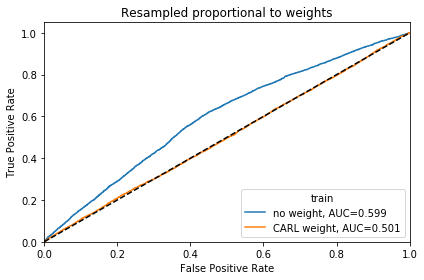

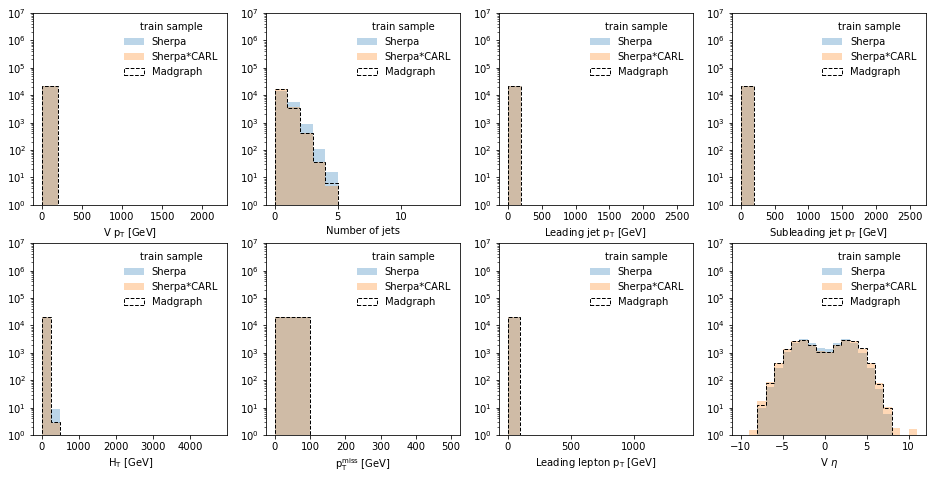

In [10]:
_, r_hat, _ = carl.evaluate(x='data/'+do+'/x0_train.npy')
w = 1./r_hat
loading.load_result(x0='data/'+do+'/x0_train.npy',
                    x1='data/'+do+'/x1_train.npy',
                    weights=w,
                    label = 'train',
                    do = do)

evaluate weights on test sample

INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x0_test.npy into RAM
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x0_test.npy as memory map
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x1_train.npy as memory map
INFO:ml.utils.plotting:CARL weighted test AUC is 0.497
INFO:ml.utils.plotting:Unweighted test AUC is 0.601
INFO:ml.utils.plotting:Saving ROC plots to /plots


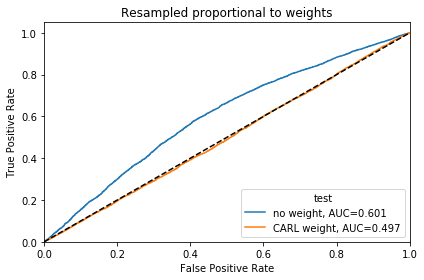

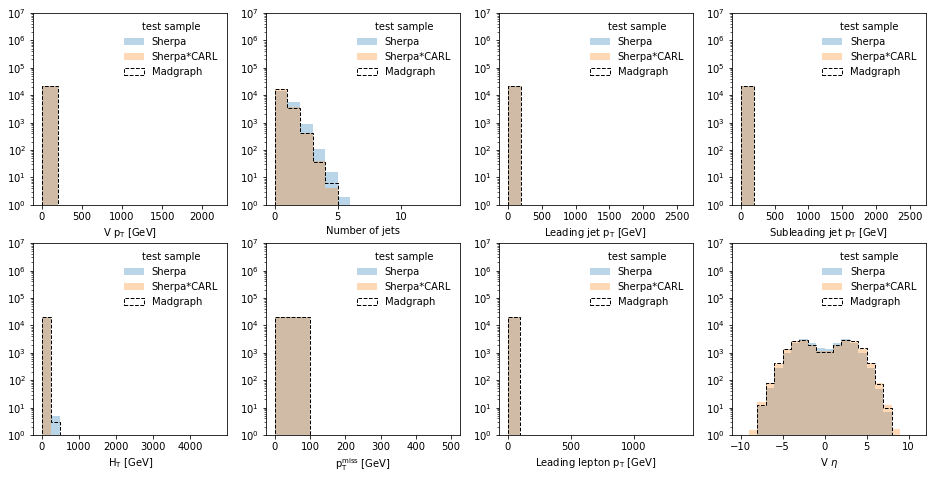

In [11]:
_, r_hat, _ = carl.evaluate(x='data/'+do+'/x0_test.npy')
w = 1./r_hat
loading.load_result(x0='data/'+do+'/x0_test.npy',
                    x1='data/'+do+'/x1_train.npy',
                    weights=w,
                    label = 'test',
                    do = do)

calibrated the output of the classifier, and re-evaluate weights on test and training samples

INFO:ml.base:Loading model from models/sherpaVsMG5_carl
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x_train.npy into RAM
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x_train.npy into RAM
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/y_train.npy into RAM
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x_train.npy into RAM
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/y_train.npy as memory map
INFO:ml.utils.plotting:Saving calibration curves to /plots


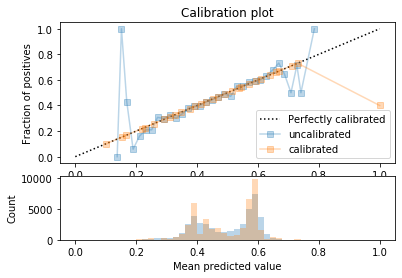

In [12]:
from ml.calibration import CalibratedClassifier
loading = Loader()

carl = RatioEstimator()
carl.load('models/'+do+'_carl')
X  = 'data/'+do+'/x_train.npy'
y  = 'data/'+do+'/y_train.npy'
s_hat, r_hat, _ = carl.evaluate(X)
calib = CalibratedClassifier(carl)
calib.fit(X = X,y = y)
p0, p1, r_cal = calib.predict(X = X)
w_cal = 1/r_cal
loading.load_calibration(y_true = y,
                         p1_raw = s_hat,
                         p1_cal = p1,
                         label = 'calibrated',
                         do = do)

In [ ]:
p0, p1, r_cal = calib.predict(X = 'data/'+do+'/x0_train.npy')
w = 1./r_cal
loading.load_result(x0='data/'+do+'/x0_train.npy',
                    x1='data/'+do+'/x1_train.npy',
                    weights=w,
                    label = 'train calibrated',
                    do = do)

INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x0_train.npy into RAM
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x0_train.npy as memory map
INFO:ml.utils.tools:  Loading data/sherpaVsMG5/x1_train.npy as memory map
